In [68]:
#This file is only looking at the roster plots for old organoid data
import networkx as nx
import numpy as np
import pickle
import pandas as pd
from scipy.io import loadmat
import h5py
from scipy.ndimage import gaussian_filter
from scipy.signal import correlate, gaussian
from scipy.ndimage import gaussian_filter1d
from tqdm import tqdm
import itertools
from pathlib import Path
import torch
from torch.nn import functional as F
from matplotlib import pyplot as plt

In [126]:
ALL_FILES = [
    # "2950_spike_mat_or_rand", #26
    "2953_spike_mat_or_rand", #Tal paper
    # "2957_spike_mat_or_rand",
    # "5116_spike_mat_or_rand",
]
# Load your .mat file


for idx, fn in enumerate(ALL_FILES):
        data = loadmat(f"{fn}.mat")



# Extracting all variables from the .mat file
t_spk_mat = data['t_spk_mat']
print(t_spk_mat.shape)
t_spk_mat_rand = data['t_spk_mat_rand']

# Creating DataFrames for each variable
# DataFrame for 't_spk_mat'
df_t_spk_mat = pd.DataFrame(t_spk_mat)

# DataFrame for 't_spk_mat_rand'
df_t_spk_mat_rand = pd.DataFrame(t_spk_mat_rand)

# # Displaying the shape of each DataFrame as a quick check
# df_shapes = {
#     't_spk_mat': df_t_spk_mat.shape,
#     't_spk_mat_rand': df_t_spk_mat_rand.shape
# }
# # df_shapes
print(t_spk_mat)


(180000, 131)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


5131


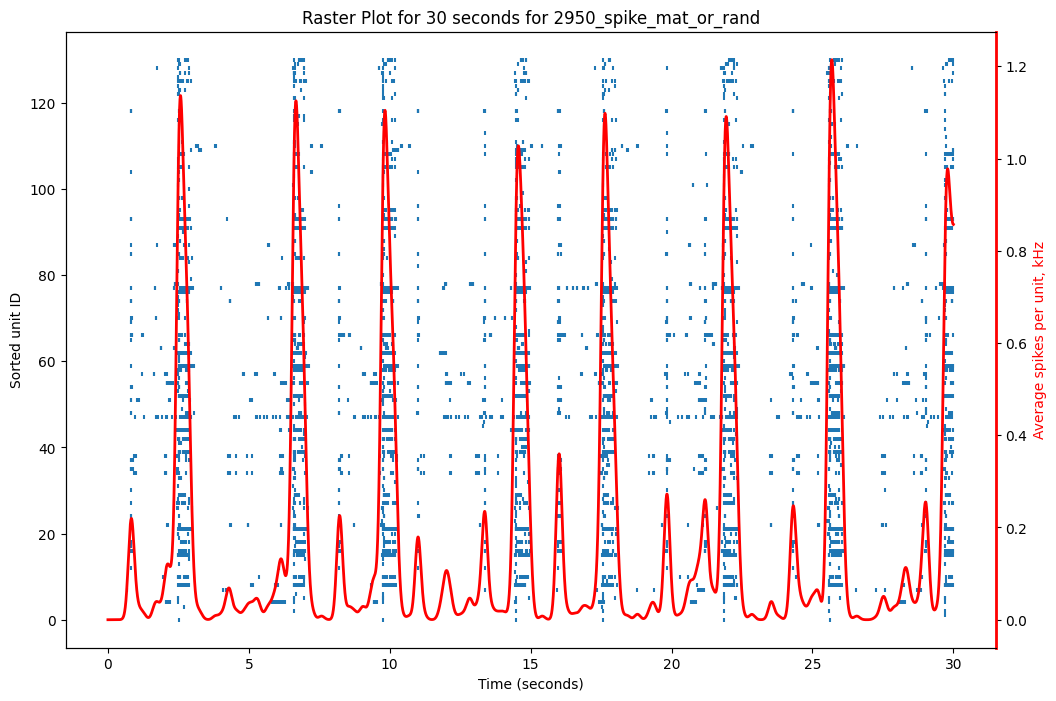

In [125]:


"""
    Raster plots for 3 min of recording

    Parameters:
    - spike_times: 2D array-like, where each row represents a time unit and each column a neuron.
    - units: int, total number of time units.
    - unit_duration_ms: int, duration of each time unit in milliseconds.
    - total_minutes: int, total time span in minutes.
    """


fig1, ax1 = plt.subplots(figsize=(12, 8))
    # Finding the indices where spikes occur
    #the first array in the tuple contains the row indices of the non-zero elements.
    # The second array contains the corresponding column indices.
spike_indices = t_spk_mat[:30*1000].nonzero()
    #total number of spikes
print(len(spike_indices[0]))

# Plotting the raster plot and average spikes per unit
ax1.scatter(spike_indices[0] / 1000.0, spike_indices[1], marker='|', s=10)

ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('Sorted unit ID')
ax1.set_title('Raster Plot for 30 seconds for 2950_spike_mat_or_rand')
avg_spikes = np.sum(t_spk_mat, axis=1)[:30*1000]
# cast to float
avg_spikes = avg_spikes.astype(float)
# Apply gaussian smoothing with kernel width 100 to avg_spikes
avg_spikes_smooth = gaussian_filter1d(avg_spikes, 100)

ax2 = ax1.twinx()
xs = np.linspace(0, len(avg_spikes), len(avg_spikes)) / 1000.0
ax2.plot(xs, avg_spikes_smooth, color='red', linewidth=2)
# make y-axis red
ax2.yaxis.label.set_color('red')
ax2.set_ylabel('Average spikes per unit, kHz')
# Draw red line for y axis with width 2
ax2.spines['right'].set_color('red')
ax2.spines['right'].set_linewidth(2)
plt.show()



In [81]:
#Gaussian smoothing with 100 ms window


import numpy as np
from scipy.ndimage import gaussian_filter1d

# Function to calculate firing rates
def calculate_firing_rates(spike_data, window_size_units, unit_duration_ms=10):
    """
    Converts spike data to firing rates using a specified window size.

    Parameters:
    - spike_data: 2D array-like, binary spike data with shape (time, neurons).
    - window_size_units: int, window size in units (each unit represents unit_duration_ms milliseconds).
    - unit_duration_ms: int, duration of each time unit in milliseconds.
    
    Returns:
    - firing_rates: 2D array, firing rates with shape (time, neurons).
    """
    # Convert window size from units to seconds
    window_duration_s = window_size_units * unit_duration_ms / 1000.0
    
    # Initialize firing rates array
    firing_rates = np.zeros_like(spike_data, dtype=float)
    
    # Calculate firing rates
    for neuron in range(spike_data.shape[1]):
        # Count spikes in each window for this neuron
        spike_counts = np.convolve(spike_data[:, neuron], np.ones(window_size_units), mode='same')
        # Convert spike counts to rates
        firing_rates[:, neuron] = spike_counts / window_duration_s
    
    return firing_rates

# Function to apply Gaussian smoothing
def gaussian_smooth(data, sigma_units):
    """
    Applies Gaussian smoothing to the data.

    Parameters:
    - data: 2D array, data to smooth.
    - sigma_units: float, standard deviation for Gaussian kernel in units.
    
    Returns:
    - smoothed_data: 2D array, smoothed data.
    """
    smoothed_data = gaussian_filter1d(data, sigma=sigma_units, axis=0)
    return smoothed_data

# Calculate firing rates
firing_rates = calculate_firing_rates(t_spk_mat, window_size_units=10)  # 100 ms window

# Apply Gaussian smoothing
# Sigma is related to the window size; adjust based on desired smoothing
sigma_units = 2  # Example sigma, adjust as needed
smoothed_firing_rates = gaussian_smooth(firing_rates, sigma_units=sigma_units)

# Now smoothed_firing_rates contains the firing rates after Gaussian smoothing


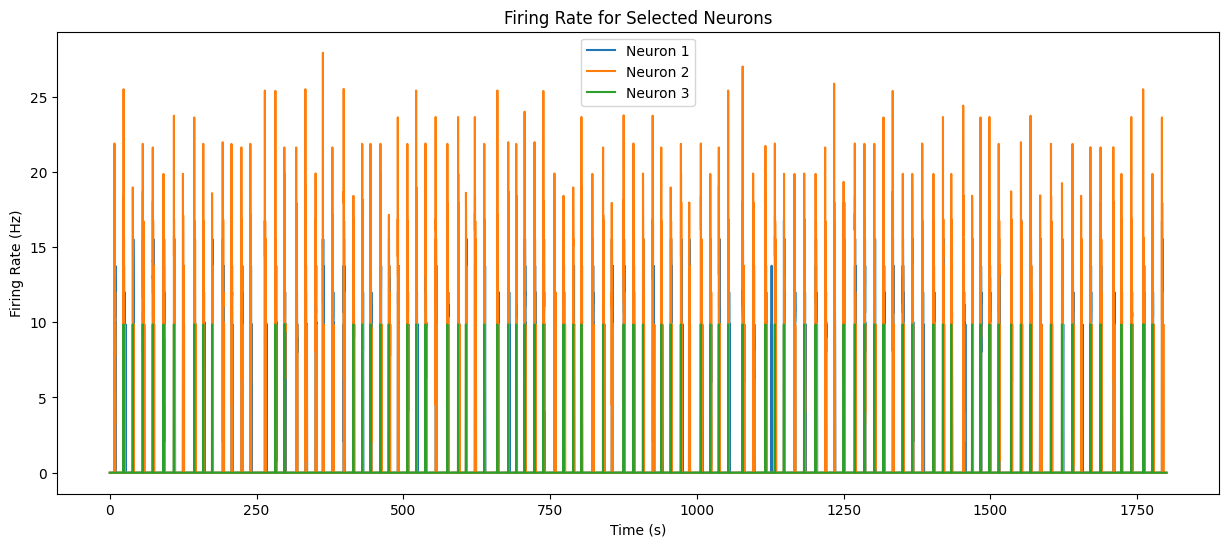

In [76]:
def plot_firing_rate_waves(firing_rates, start_neuron=0, end_neuron=10):
    """
    Plots the firing rates of a subset of neurons over time, showing the wave-like patterns.

    Parameters:
    - firing_rates: 2D array, firing rates with shape (time, neurons).
    - start_neuron: int, index of the first neuron to plot.
    - end_neuron: int, index of the last neuron to plot (non-inclusive).
    """
    plt.figure(figsize=(15, 6))

    # Time vector (assuming each time unit represents 10 ms)
    time_units = firing_rates.shape[0]
    time_vector = np.linspace(0, time_units * 10 / 1000, time_units)  # Convert units to seconds

    for neuron in range(start_neuron, min(end_neuron, firing_rates.shape[1])):
        plt.plot(time_vector, firing_rates[:, neuron], label=f'Neuron {neuron+1}')

    plt.xlabel('Time (s)')
    plt.ylabel('Firing Rate (Hz)')
    plt.title('Firing Rate for Selected Neurons')
    plt.legend()
    plt.show()

# Plot firing rate waves for the first 10 neurons as an example
plot_firing_rate_waves(smoothed_firing_rates, 0, 3)
